# Halo Orbits and NRHO

The objective of this tutorial is to provide some basic function to assess the properties of a Halo orbit about Libration point L2 in the Earth-Moon system.

In [1]:
import r3bpy
from r3bpy.main import Problem
from r3bpy.orbits import print_info
import r3bpy.core as constants

import numpy as np

## RTBP definition

Let's define the RTBP for the Earth - Moon system.

In [2]:
r12 = constants.DISTANCE_EARTH_MOON
m1 = constants.MU_EARTH
m2 = constants.MU_MOON
problem = Problem(m1, m2, r12)
mu_ratio = problem.get_mu_ratio()
DU = problem.get_distance_normalisation()
TU = problem.get_time_normalisation()

print("Mu: ", mu_ratio)
synodic_period = problem.get_synodic_period() / 86400.
print("synodic_period: {} days".format(synodic_period))

Mu:  0.012150586632602434
synodic_period: 27.42228008298945 days


In [3]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [10, 10]
from r3bpy.visu import plot_trajectory, plot_system

## Orbit

We construct a Halo orbit around Libration point L1 in the RTBP.

In [5]:
from r3bpy.orbits import HaloOrbit

Ax = 5000e3 / r12  # amplitude of the lissajous orbit
libration_point = problem.get_libration_point_info(r3bpy.main.L1)
halo_l1 = HaloOrbit(libration_point)
halo_l1_orbit = halo_l1.find_orbit(Ax, False, 200, 1e-10)

In [6]:
print_info(halo_l1_orbit)
print("Orbit amplitudes: ", halo_l1_orbit.Ax, halo_l1_orbit.Ay, halo_l1_orbit.Az)

Orbit type           : halo
      period         : 2.744300
      Libration Point: L0
      Primaries      :  
Orbit amplitudes:  0.015899806930014138 0.0 0.01296371197743277


We have to propagate the orbit before plotting it.

In [8]:
orbit_period_day = halo_l1_orbit.period
t, xyz_halo = halo_l1_orbit.propagate([0, orbit_period_day])  
xyz_halo = np.array(xyz_halo)

<Axes3DSubplot:xlabel='x (DU)', ylabel='y (DU)'>

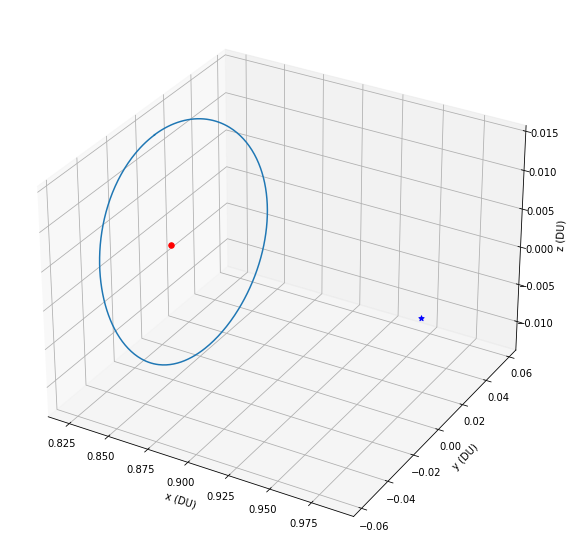

In [9]:
ax, fig = r3bpy.visu.init_figure(False)
plot_trajectory(xyz_halo, ax=ax)
plot_system(problem, is2d=False, ax=ax, primaryList=[2], colinearPointsList=[1], withTriangularPoints=False)

Let's propagate on a longer period to plot then the trajectories in an inertial frame.

In [10]:
sim_period_sec = problem.get_synodic_period() 
sim_period_day = sim_period_sec / 86400
t, xyz_halo = halo_l1_orbit.propagate([0, sim_period_day])  
xyz_halo = np.array(xyz_halo)

Perform frame transformation

In [11]:
from r3bpy.main import Frame

p = [x[0:3] for x in xyz_halo]
t = [x for x in t]

f = Frame(problem)
xyz_halo_in = f.to_frame(t, list(p))

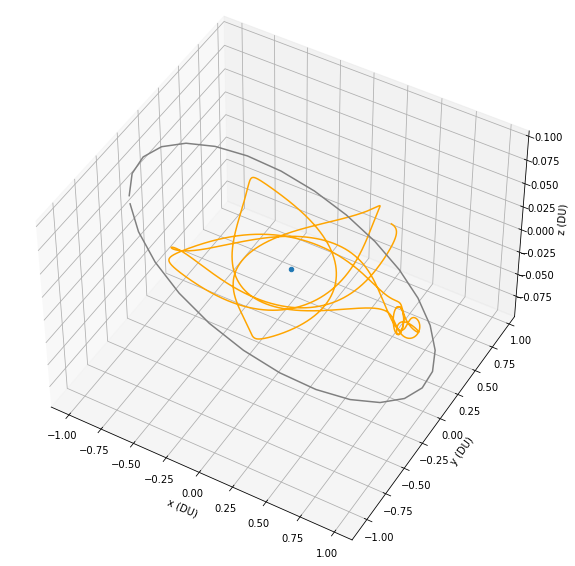

In [12]:
from r3bpy.main.bodies import Moon
from r3bpy.visu import plot_orbit

ax, fig = r3bpy.visu.init_figure(False)
plot_trajectory(xyz_halo_in, color='orange', ax=ax)
Moon.plot_orbit( [0., sim_period_day], ax, color='grey', a_m=1/DU)
ax.scatter(0,0,0) # Earth
ax.view_init(elev=45.) 

## Family

We now construct a family of Halo orbits around Libration point L2.

In [13]:
libration_point = problem.get_libration_point_info(r3bpy.main.L2)

AxInit = 10000.0 / r12
AxFinal = 30000.0e3 / r12
AxStep = 1000.0e3 / r12
ax_grid = np.arange(AxInit, AxFinal, AxStep)

We compute the family iteratively, using a discrete continuation scheme on one of the orbit parameter.

In [14]:
halo_family = HaloOrbit(libration_point)
halo_information = {"parameter": [], "periapsis":[], "mnu":[], "mnu1":[], "mnu2":[], "period": []}

halo_family_sols = []

minStep = 10e3 / r12

current_halo_orbit = None
x = AxInit
xold = x
current_step = AxStep
while (x < AxFinal) and current_step > minStep:
    if current_halo_orbit is None:
        orbit = halo_family.find_orbit(x, False, 50, 1e-6, 1.0)
    else:  # use previous solution to compute new Halo
        try:
            orbit = halo_family.find_orbit(x, current_halo_orbit, False, 20, 1e-6, 1.)        
        except RuntimeError:
            orbit = None

    if (orbit and orbit.is_valid) and (orbit is not None):
        current_halo_orbit = orbit
        halo_family_sols.append(current_halo_orbit)        
        halo_information["periapsis"].append(x);
        halo_information["parameter"].append(current_halo_orbit.get_periapsis(r3bpy.main.P2))
        halo_information["mnu"].append(current_halo_orbit.get_stability_index())
        halo_information["mnu1"].append(current_halo_orbit.mnu1)
        halo_information["mnu2"].append(current_halo_orbit.mnu2)
        halo_information["period"].append(current_halo_orbit.period)
        current_step = AxStep
        xold = x
        x = xold + current_step
    else:
        #current_halo_orbit = None
        current_step = current_step / 2
        x = xold + current_step

Plot

<Axes3DSubplot:>

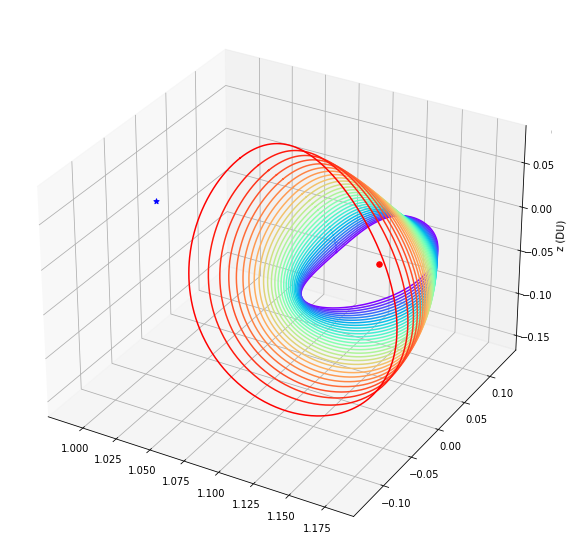

In [15]:
colors = plt.cm.rainbow(np.linspace(0, 1, len(halo_family_sols)))
icolor = 0

ax, fig = r3bpy.visu.init_figure(False)
ax = plt.axes(projection='3d')
for current_halo_orbit in halo_family_sols:    
    ax = r3bpy.visu.plot_orbit(current_halo_orbit, color=colors[icolor], ax=ax)
    icolor = icolor + 1
plot_system(problem, is2d=False, ax=ax, primaryList=[2], colinearPointsList=[2], withTriangularPoints=False)

## Stability

We unnormalised the computed data.

In [16]:
p = np.array(halo_information["periapsis"]) * DU / 1000.
halo_period = np.array(halo_information["period"]) * TU / 86400.

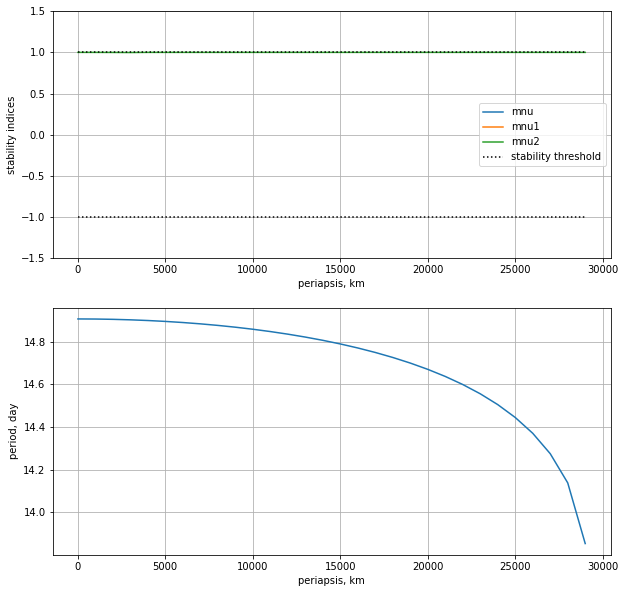

In [17]:
fig = plt.figure()
ax = fig.add_subplot()

ax = plt.subplot(2,1,1)
ax.plot(p, np.array(halo_information["mnu"]), label="mnu")
ax.plot(p, np.array(halo_information["mnu1"]), label="mnu1")
ax.plot(p, np.array(halo_information["mnu2"]), label="mnu2")
ax.plot(p, 1 * np.ones(len(p)), "k:", label="stability threshold")
ax.plot(p,-1 * np.ones(len(p)), "k:")
ax.grid()
ax.legend()
ax.set_ylim([-1.5, 1.5])
ax.set_ylabel('stability indices')
ax.set_xlabel('periapsis, km')

ax = plt.subplot(2,1,2)
ax.plot(p, halo_period)
ax.grid()
ax.set_ylabel('period, day')
ax.set_xlabel('periapsis, km')

plt.show()

The stability indices must be understood in the linear sense. Indiex between -1, and  1 means that the orbit is marginally stable (in the linear sense).

## Resonance

Orbit resonnance indicates its repeativity with respect to the synodical period.

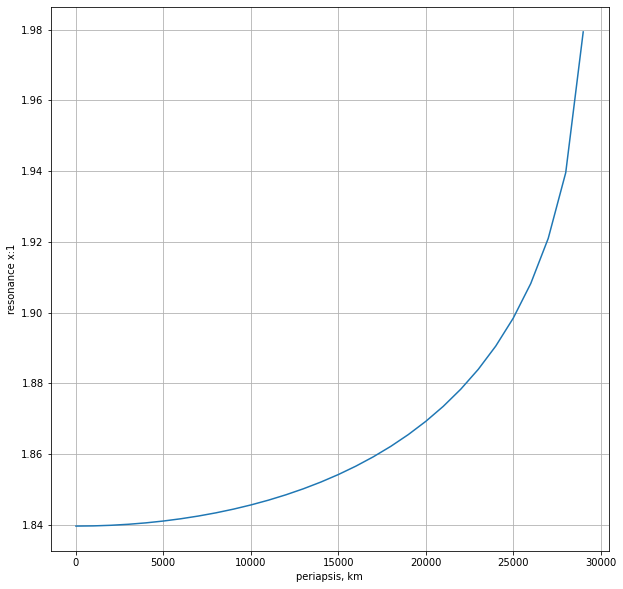

In [18]:
DU = problem.get_distance_normalisation()
TU = problem.get_time_normalisation()

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(p, synodic_period / halo_period)
ax.grid()
ax.set_ylabel('resonance x:1')
ax.set_xlabel('periapsis, km')

plt.show()

The x:1 synodic resonance indicates that the spacecraft completes y revolutions of the halo orbit in one lunar synodic period.